<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Setting up Polytropic [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Initial Data, in Curvilinear Coordinates

## Authors: Zach Etienne, Phil Chang, and Leo Werneck
### Formatting improvements courtesy Brandon Clark

## This module sets up initial data for a TOV star in *spherical, isotropic coordinates*, using the *Numerical* ADM Spherical to BSSN Curvilinear initial data module (numerical = BSSN $\lambda^i$'s are computed using finite-difference derivatives instead of exact expressions).

**Notebook Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [plots](#convergence) at bottom). Note that convergence at the surface of the star will be lower order due to the sharp drop to zero in $T^{\mu\nu}$.</font>

### NRPy+ Source Code for this module: 

* [TOV/TOV_Solver.py](../edit/TOV/TOV_Solver.py); ([**NRPy+ Tutorial module reviewing mathematical formulation and equations solved**](Tutorial-ADM_Initial_Data-TOV.ipynb)); ([**start-to-finish NRPy+ Tutorial module demonstrating that initial data satisfy Hamiltonian constraint**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb)): Tolman-Oppenheimer-Volkoff (TOV) initial data; defines all ADM variables and nonzero $T^{\mu\nu}$ components in Spherical basis.
* [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
* [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

## Introduction:
Here we use NRPy+ to set up initial data for a [simple polytrope TOV star](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation).

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration [(**NRPy+ tutorial on NRPy+ Method of Lines algorithm**)](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on TOV initial data**](Tutorial-ADM_Initial_Data-TOV.ipynb)
    * [**NRPy+ tutorial on validating TOV initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb).
1. Evaluate the Hamiltonian constraint violation
    * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence of Hamiltonian constraint violation to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
1. [Step 2](#tov_solution): Solve TOV equations to generate initial data
1. [Step 3](#adm_id_spacetime): Register C functions for interpolating TOV initial data onto our numerical grids, converting TOV metric quantities to BSSN, and constructing $T^{\mu\nu}$
1. [Step 4](#ham_const_output): Register C functions for outputting the Hamiltonian constraint

1. [Step 5](#cparams_rfm_and_domainsize) Output `free_parameters.h`, which sets numerical grid parameters
1. [Step 6](#mainc): Register the `main()` C code for generating the `TOV_Playground` executable
1. [Step 7](#nrpy_infra_codes): Register the core NRPy+ infrastructure C codes that set up needed data structures, C macros, etc.
1. [Step 8](#output_compile_and_run): Output all C codes, compile `TOV_Playground`, and run at two resolutions
1. [Step 9](#visualize_output): Visualize output
1. [Step 10](#convergence): Code validation test: confirm numerical errors (Hamiltonian constraint violation) converge to zero as expected
1. [Step 11](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initalizenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$


In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import outputC,add_to_Cfunction_dict # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import sympy as sp               # SymPy: The Python computer algebra package upon which NRPy+ depends
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions
import diagnostics_generic.process_2D_data as plot2D  # NRPy+: analysis of output data
import diagnostics_generic.output_yz_or_xy_plane as planar_diags  # NRPy+: C code for generating output data

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("TOVID_Ccodes_new_way/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step 1: Set the spatial dimension parameter
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()

# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size     = 7.5 # SET BELOW BASED ON TOV STELLAR RADIUS

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial finite difference derivatives;
#           and the core data type.
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.

# Step 3: Polytropic EOS setup
# For EOS_type, choose either "SimplePolytrope" or "PiecewisePolytrope"
EOS_type = "SimplePolytrope"
# If "PiecewisePolytrope" is chosen as EOS_type, you
#   must also choose the name of the EOS, which can
#   be any of the following:
# 'PAL6', 'SLy', 'APR1', 'APR2', 'APR3', 'APR4',
# 'FPS', 'WFF1', 'WFF2', 'WFF3', 'BBB2', 'BPAL12',
# 'ENG', 'MPA1', 'MS1', 'MS2', 'MS1b', 'PS', 'GS1',
# 'GS2', 'BGN1H1', 'GNH3', 'H1', 'H2', 'H3', 'H4',
# 'H5', 'H6', 'H7', 'PCL2', 'ALF1', 'ALF2', 'ALF3',
# 'ALF4'
EOS_name = 'SLy' # <-- IGNORED IF EOS_type is not PiecewisePolytrope.

In [2]:
# Step 4: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

<a id='tov_solution'></a>

# Step 2: Solve TOV equations to generate initial data \[Back to [top](#toc)\]
$$\label{tov_solution}$$

As documented [in the TOV Initial Data NRPy+ Tutorial Module](Tutorial-TOV_Initial_Data.ipynb) ([older version here](Tutorial-GRMHD_UnitConversion.ipynb)), we will now set up TOV initial data, storing the densely-sampled result to file (***Courtesy Phil Chang***).

`scipy` provides the ODE integration routine used in our TOV solver, so we first make sure that it is installed:

In [3]:
!pip install scipy > /dev/null

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


Next we call the [`TOV.TOV_Solver()` function](../edit/TOV/TOV_Solver.py) ([NRPy+ Tutorial module](Tutorial-ADM_Initial_Data-TOV.ipynb)) to set up the initial data, using the default parameters for initial data. This function outputs the solution to a file named `outputTOVpolytrope.txt`.

In [4]:
##########################
# Polytropic EOS example #
##########################
import TOV.Polytropic_EOSs as ppeos

if EOS_type == "SimplePolytrope":
    # Set neos = 1 (single polytrope)
    neos = 1

    # Set rho_poly_tab (not needed for a single polytrope)
    rho_poly_tab = []

    # Set Gamma_poly_tab
    Gamma_poly_tab = [2.0]

    # Set K_poly_tab0
    K_poly_tab0 = 1. # ZACH NOTES: CHANGED FROM 100.

    # Set the eos quantities
    eos = ppeos.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)
    rho_baryon_central = 0.129285
elif EOS_type == "PiecewisePolytrope":
    eos = ppeos.set_up_EOS_parameters__Read_et_al_input_variables(EOS_name)
    rho_baryon_central=2.0
else:
    print("""Error: unknown EOS_type. Valid types are 'SimplePolytrope' and 'PiecewisePolytrope' """)
    sys.exit(1)

import TOV.TOV_Solver as TOV
M_TOV, R_Schw_TOV, R_iso_TOV = TOV.TOV_Solver(eos,
                                              outfile=os.path.join(Ccodesrootdir, "TOVdata.txt"),
                                              rho_baryon_central=rho_baryon_central,
                                              return_M_RSchw_and_Riso = True,
                                              verbose = True)

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size = 2.0 * R_iso_TOV

(1256, 1256, 1256, 1256, 1256, 1256)
Just generated a TOV star with
* M        = 1.405030336771405e-01 ,
* R_Schw   = 9.566044579232513e-01 ,
* R_iso    = 8.100085557410308e-01 ,
* M/R_Schw = 1.468768334847266e-01 



<a id='adm_id_spacetime'></a>

# Step 3: Register C functions for interpolating TOV initial data onto our numerical grids, converting TOV metric quantities to BSSN, and constructing $T^{\mu\nu}$ \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

First we register all the C functions needed to read the TOV data file, interpolate the TOV solution to our numerical grid, and convert the TOV quantities to ADM variables and $T^{\mu\nu}$.

In [5]:
import TOV.TOV_Ccodegen_library as TOVCL  # NRPy+: TOV C codegen library
TOVCL.add_to_Cfunction_dict_TOV_read_data_file_set_ID_persist(interp_stencil_size=12)
TOVCL.add_to_Cfunction_dict_TOV_ID_function()
TOVCL.add_to_Cfunction_dict_TOV_interpolate_1D()

Next we call the "universal translator" [`BSSN.Initial_Data_Reader__BSSN_Converter`](../edit/BSSN.Initial_Data_Reader__BSSN_Converter.py) ([documentation](Tutorial-ADM_Initial_Data_Reader__BSSN_Converter.ipynb)), which converts the ADM quantities to BSSN in our desired reference metric.

In [6]:
import BSSN.ADM_Initial_Data_Reader__BSSN_Converter as IDread
IDread.register_C_functions_and_NRPy_basic_defines(input_Coord="Spherical",
                                                   ID_persist_struct_contents_str=TOVCL.ID_persist_str(),
                                                   include_T4UU=True)

<a id='ham_const_output'></a>

# Step 4: Register C functions for outputting the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{ham_const_output}$$

In our start-to-finish C code below, we will evaluate the Hamiltonian constraint violation of the TOV data on our numerical grid. The idea is, this quantity should drop to zero with increasing numerical resolution, at a rate consistent with our finite differencing operator's truncation error.

The Hamiltonian constraint $\mathcal{H}$ [as implemented in this corresponding NRPy+ tutorial notebook](Tutorial-BSSN_constraints.ipynb) depends on the Ricci tensor. As is done when we evolve our initial data forward in time, we first compute Ricci, then $\mathcal{H}$, as this breaks up the large symbolic expression for $\mathcal{H}$, decreasing the time needed to generate the C codes. Here we register functions for both computing the Ricci tensor and $\mathcal{H}$:

In [7]:
import BSSN.BSSN_Ccodegen_library as BCl
_ignore = BCl.add_Ricci_eval_to_Cfunction_dict(includes=["NRPy_basic_defines.h"], rel_path_to_Cparams=os.path.join("."),
                                               enable_rfm_precompute=False, enable_golden_kernels=False, enable_SIMD=False,
                                               enable_split_for_optimizations_doesnt_help=False, OMP_pragma_on="i2")

_ignore = BCl.add_BSSN_constraints_to_Cfunction_dict(includes=["NRPy_basic_defines.h"],
                                                     rel_path_to_Cparams=os.path.join("."), output_H_only=True,
                                                     enable_rfm_precompute=False, enable_SIMD=False,
                                                     enable_stress_energy_source_terms=True,
                                                     leave_Ricci_symbolic=True)

Generating symbolic expressions for 3-Ricci tensor (Spherical coords)...
Finished generating symbolic expressions for 3-Ricci tensor (Spherical coords) in 0.8 seconds. Next up: C codegen...
Generating C code for 3-Ricci tensor (FD order=4) (Spherical coords)...
Finished generating C code for 3-Ricci tensor (FD order=4) (Spherical coords) in 20.2 seconds.
Generating symbolic expressions for BSSN constraints (Spherical coords)...
Finished generating symbolic expressions for BSSN constraints (Spherical coords) in 1.5 seconds. Next up: C codegen...
Generating C code for BSSN constraints (FD order=4) (Spherical coords)...
Finished generating C code for BSSN constraints (FD order=4) (Spherical coords) in 3.2 seconds.


<a id='cparams_rfm_and_domainsize'></a>

# Step 5: Output `free_parameters.h`, which sets numerical grid parameters \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Here we output `free_parameters.h`, which sets the size of the numerical grid based on the star's radius, as prescribed in the variable `domain_size` (set above). Also free parameters based on chosen reference metric (set above) overwrite defaults set in [`reference_metric.py`](reference_metric.py).

In [8]:
# Step 3.a.i: Set free_parameters.h
# Output to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.

outstr = ""
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='mainc'></a>

# Step 6: Register the `main()` C code for generating the `TOV_Playground` executable \[Back to [top](#toc)\]
$$\label{mainc}$$

As a core diagnostic, we will output grid data on the $yz$ plane. This diagnostic is constructed within the Python module [`diagnostics_generic.output_yz_or_xy_plane`](diagnostics_generic/output_yz_or_xy_plane.py).

In [9]:
# T4UU00 = e^{-nu} rho, while alpha = e^{nu/2} -> T4UU00 = rho/alpha^2 -> rho = T4UU00*alpha^2
list_of_outputs = ["y_n_gfs[IDX4ptS(CFGF,idx)]",
                   "log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)]))",
                   "y_n_gfs[IDX4ptS(ALPHAGF,idx)]*y_n_gfs[IDX4ptS(ALPHAGF,idx)] * griddata->gridfuncs.auxevol_gfs[IDX4ptS(T4UU00GF,idx)]",]
planar_diags.add_to_Cfunction_dict__plane_diagnostics(plane="yz", include_ghosts=False,
                                                      list_of_outputs=list_of_outputs, num_sig_figs=4)

Next we register the `main()` function for our `TOV_Playground` executable.

In [10]:
def add_to_Cfunction_dict_main__TOV_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h", "time.h"]
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Output data on xy plane to file.
// Step 3: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""  griddata_struct griddata;
  set_Cparameters_to_default(&griddata.params);

  // Step 0.b: Read command-line input, error out if nonconformant
  if((argc != 4) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
    fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
    fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  // Step 0.c: Check grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

#include "free_parameters.h"

  // Step 0.d: Uniform coordinate grids are stored to *xx[3]
  // Step 0.d.i: Set bcstruct
  {
    // Step 0.f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
  }

  // Step 0.j: Allocate memory for y_n_gfs gridfunctions
  const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
  const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
  const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;
  const int grid_size = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
  griddata.gridfuncs.y_n_gfs = (REAL *restrict)malloc(sizeof(REAL)*grid_size*NUM_EVOL_GFS);
  griddata.gridfuncs.auxevol_gfs = (REAL *restrict)malloc(sizeof(REAL)*grid_size*NUM_AUXEVOL_GFS);

  // Step 0.l: Set up initial data to an exact solution
  ID_persist_struct ID_persist;
  TOV_read_data_file_set_ID_persist("TOVdata.txt", &ID_persist);

  initial_data_reader__convert_to_BSSN_from_ADM_Spherical(&griddata, &ID_persist, TOV_ID_function);

  REAL *restrict aux_gfs = (REAL *restrict)malloc(sizeof(REAL)*grid_size*NUM_AUX_GFS);

  // To simplify the expressions somewhat, we compute & store the Ricci tensor separately
  //    from the BSSN constraints.
  Ricci_eval(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);
  BSSN_constraints(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, aux_gfs);

  yz_plane_diagnostics(&griddata, griddata.gridfuncs.y_n_gfs, aux_gfs);

  // Step 4: Free all allocated memory
  free(griddata.gridfuncs.y_n_gfs);
  free(griddata.gridfuncs.auxevol_gfs);
  free(aux_gfs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);

  return 0;
"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

In [11]:
add_to_Cfunction_dict_main__TOV_Playground()

<a id='nrpy_infra_codes'></a>

# Step 7: Register the core NRPy+ infrastructure C codes that set up needed data structures, C macros, etc. \[Back to [top](#toc)\]
$$\label{nrpy_infra_codes}$$

In [12]:
import outputC as outC
import finite_difference as fin
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=True, enable_SIMD=False)

outC.outC_NRPy_basic_defines_h_dict["MoL"] = """
typedef struct __MoL_gridfunctions_struct__ {
  REAL *restrict y_n_gfs;
  REAL *restrict auxevol_gfs;
} MoL_gridfunctions_struct;
"""
par.register_NRPy_basic_defines()  # add `paramstruct params` to griddata struct.
list_of_extras_in_griddata_struct = ["MoL_gridfunctions_struct gridfuncs;"]
gri.register_C_functions_and_NRPy_basic_defines(list_of_extras_in_griddata_struct=list_of_extras_in_griddata_struct)  # #define IDX3S(), etc.

rfm.register_C_functions(use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines()

outC.outputC_register_C_functions_and_NRPy_basic_defines()
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=False)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

<a id='output_compile_and_run'></a>

# Step 8: Output all C codes, compile `TOV_Playground`, and run at two resolutions \[Back to [top](#toc)\]
$$\label{output_compile_and_run}$$

Finally, output all the C codes (and auto-generated `Makefile`) to `Ccodesrootdir/`, compile them, and run the executable at two numerical resolutions. We run at two resolutions to check that the Hamiltonian constraint violation converges to zero at a rate consistent with the order of our finite-difference operators.

In [13]:
cmd.new_C_compile(Ccodesrootdir, "TOV_Playground", mkdir_Ccodesrootdir=False,
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported

# Change to output directory
os.chdir(os.path.join(Ccodesrootdir))
# Clean up existing output files
cmd.delete_existing_files("out??.txt")

cmd.Execute("TOV_Playground", "48 12 2", file_to_redirect_stdout="out48.txt")
cmd.Execute("TOV_Playground", "96 12 2", file_to_redirect_stdout="out96.txt")

(EXEC): Executing `make -j18`...
TOV_ID_function.c: In function ‘TOV_ID_function’:
TOV_ID_function.c:11:21: warning: variable ‘phi’ set but not used [-Wunused-but-set-variable]
   11 |   REAL rbar, theta, phi;
      |                     ^~~
(BENCH): Finished executing in 2.22 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./TOV_Playground 48 12 2`...
(BENCH): Finished executing in 0.22 seconds.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./TOV_Playground 96 12 2`...
(BENCH): Finished executing in 0.22 seconds.


<a id='visualize_output'></a>

# Step 9: Visualize output \[Back to [top](#toc)\]
$$\label{visualize_output}$$

Next we visualize the output on the $yz$ plane, analyzing the Hamiltonian constraint violation $\mathcal{H}$ and the mass-energy density $\rho$.

In [14]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
from IPython.display import Image

In [15]:
xy_extent=domain_size
# Data are in format x,y,z, CF,Ham,rho
output_grid_x, output_grid_y, output_grid_data_Ham = \
    plot2D.generate_uniform_2D_grid('out96.txt', 1,2,4, [-xy_extent,xy_extent], [-xy_extent,xy_extent])
# Ham data are in column 4 --------------------------^
output_grid_x, output_grid_y, output_grid_data_rho = \
    plot2D.generate_uniform_2D_grid('out96.txt', 1,2,5, [-xy_extent,xy_extent], [-xy_extent,xy_extent])
# rho data are in column 5 --------------------------^

output_grid_data = []
output_grid_data += [output_grid_data_Ham]
output_grid_data += [output_grid_data_rho]

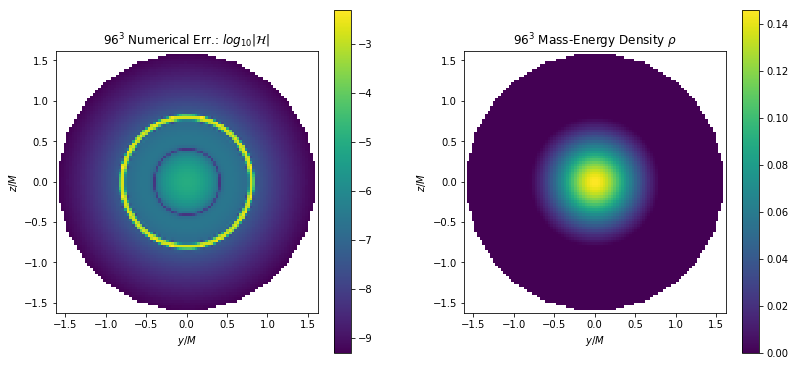

In [16]:
fig = plt.figure(figsize=(12, 6))

axN = []  # initialize axis/plot array.


Labels = [r"$96^3$ Numerical Err.: $log_{10}|\mathcal{H}|$",
          r"$96^3$ Mass-Energy Density $\rho$"]

for whichplot in range(2):
    #Generate the subplot for the each constraint
    ax = fig.add_subplot(121 + whichplot)
    axN.append(ax) # Grid of 2x1

    axN[whichplot].set_xlabel(r'$y/M$')
    axN[whichplot].set_ylabel(r'$z/M$')
    axN[whichplot].set_title(Labels[whichplot])

    figure = plt.imshow(output_grid_data[whichplot], extent=(-xy_extent,xy_extent, -xy_extent,xy_extent))
    cb = plt.colorbar(figure)

# Adjust the spacing between plots
plt.tight_layout(pad=4)

<a id='convergence'></a>

# Step 10: Code validation test: confirm numerical errors (Hamiltonian constraint violation) converge to zero as expected \[Back to [top](#toc)\]
$$\label{convergence}$$

First interpolate the 2D data for Hamiltonian constraint violation at two grid resolutions onto 1D slices along the y-axis.

In [17]:
x_extent=domain_size      # plot from -x_extent to +x_extent
sample_numpts_x = 100     # number of points to plot
interp_method = "linear"  # Could be linear (recommended), nearest (don't use; gridpoints are off-axis), or cubic

# Data are in format x,y,z, CF,Ham,rho
output_1D_grid_data48 = []
output_1D_grid_data96 = []
for i in [4]:  # H constraint is in column 4 (where x is stored in the 0th column)
    output_grid_x96, output_1D_grid_data48_i = \
        plot2D.extract_1D_slice_from_2D_data('out48.txt', 0.0,
                                      1,2,i, [-x_extent, x_extent], sample_numpts_x=sample_numpts_x,
                                      interp_method=interp_method)
    output_grid_x48, output_1D_grid_data96_i = \
        plot2D.extract_1D_slice_from_2D_data('out96.txt', 0.0,
                                      1,2,i, [-x_extent, x_extent], sample_numpts_x=sample_numpts_x,
                                      interp_method=interp_method)
    output_1D_grid_data48 += [output_1D_grid_data48_i]
    output_1D_grid_data96 += [output_1D_grid_data96_i]

Now, the equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence, plotting the Hamiltonian constraint violation (which should converge to zero) at two resolutions:

* `Nr` $\times$ `Ntheta` $\times$ `Nphi`=$48\times 12\times 2$, and 
* `Nr` $\times$ `Ntheta` $\times$ `Nphi`=$96\times 12\times 2$.

As the data are spherically symmetric, we only need to vary the resolution in the radial direction.

Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96\times 12\times 2$ grid) by a factor of $\left(96/48\right)^4$.

Here we demonstrate that when the results $48\times 12\times 2$ are rescaled by exactly a factor of $\left(48/96\right)^4$, the Hamiltonian constraint violation matches the $96\times 12\times 2$ calculation, *except* at the star's surface where the stress-energy tensor $T^{\mu\nu}$ is very sharp. This demonstrates that the constraint violation converges to zero as expected.

<Figure size 432x288 with 0 Axes>

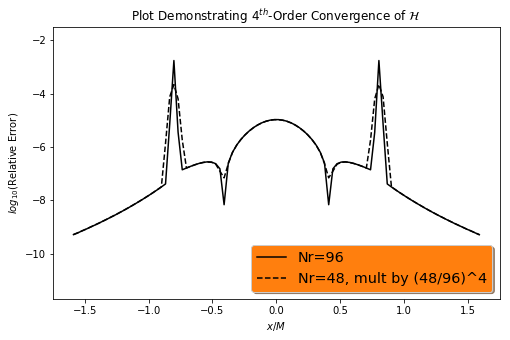

In [18]:
plt.clf()

# We want to create four plots. One for the Hamiltonian, and three for the momentum
# constrains (r,th,ph)
# Define the size of the overall figure
fig = plt.figure(figsize=(8,5))

#Generate the subplot for the each constraint
ax = fig.add_subplot(111)
ax.set_title(r"Plot Demonstrating $4^{th}$-Order Convergence of $\mathcal{H}$")
ax.set_xlabel(r"$x/M$")
ax.set_ylabel("$log_{10}$(Relative Error)")

ax.plot(output_grid_x96, output_1D_grid_data96[0], 'k-', label='Nr=96')
ax.plot(output_grid_x48, output_1D_grid_data48[0] + 4*np.log10(48./96.), 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-11.7,-1.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
# Return to Ccodesrootdir
os.chdir(os.path.join(".."))

<a id='latex_pdf_output'></a>

# Step 11: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-TOV_Initial_Data_new_way.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-TOV_Initial_Data_new_way.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [19]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-TOV_Initial_Data_new_way")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-
    TOV_Initial_Data_new_way.tex, and compiled LaTeX file to PDF file
    Tutorial-Start_to_Finish-BSSNCurvilinear-TOV_Initial_Data_new_way.pdf
